# Sentiment analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import nltk
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax
from sentence_transformers import SentenceTransformer, util
from scipy.interpolate import interp1d

nltk.download('punkt')

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
DATA_PATH = "../../data/our_movie_data_extended.csv"
df_extended = pd.read_csv(DATA_PATH)[["Wikipedia_movie_ID", "summary", "category"]]
df_extended.dropna(subset=["summary"], inplace=True)
df_extended.sample(3)

Wikipedia_movie_ID                                            summary  \
55503            24403195  Vishnu , a restless young man, itches to escap...   
57990            25626519  A newsstand owner takes pity on Qinawi, a lame...   
10165             3088107  It's a week after the rapture and the millions...   

                                                category  
55503  ['Romance', 'Others', 'Drama', 'Comedy', 'Acti...  
57990                    ['Thriller', 'Drama', 'Others']  
10165  ['Others', 'Family/Animation', 'Drama', 'Fanta...

### Version of sentiment analysis using emotions and segments

In [4]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [5]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed
threshold = 0.5

#iterate over summaries
for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    embeddings = sentence_model.encode(sentences, convert_to_tensor=True)

    # Segment the text based on cosine similarity
    segments = []
    current_segment = [sentences[0]]

    for i in range(len(sentences) - 1):
        similarity = util.pytorch_cos_sim(embeddings[i], embeddings[i + 1]).item()

        if similarity < threshold:
            segments.append(" ".join(current_segment))
            current_segment = []

        current_segment.append(sentences[i + 1])

    #final segment join
    segments.append(" ".join(current_segment))

    # Classify the segments for emotions
    out = classifier(segments)
    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['segment_id'] = [i for i in range(len(segments))]
    emotions['segment'] = [segments[i] for i in range(len(segments))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions)
    
    big_df = pd.concat([big_df, emotions], ignore_index=True)

print(big_df.shape)

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.55it/s]

(19, 10)


### Version of sentiment analysis using sentences and emotions

In [6]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)

    out = classifier(sentences)

    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['sentence_id'] = [i for i in range(len(sentences))]
    emotions['sentence'] = [sentences[i] for i in range(len(sentences))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

    big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s]

(25, 10)


### Version of sentiment analysis using positive/negative only

In [7]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
dict_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

big_df = pd.DataFrame()

limit = 10 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    for idx_s, s in enumerate(sentences):
        t_encoded = tokenizer(s, return_tensors='pt')
        t_output = model(**t_encoded)
        scores = softmax(t_output.logits.detach().numpy(), axis=1)
        
        emotions = pd.DataFrame(scores, columns=[dict_labels[i] for i in range(3)])
        emotions['sentence_id'] = idx_s
        emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

        big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]

(297, 5)


In [8]:
big_df.head(20)

negative   neutral  positive  sentence_id  Wikipedia_movie_ID
0   0.005653  0.821786  0.172561            0                 330
1   0.255226  0.724555  0.020220            0                3217
2   0.755420  0.235866  0.008714            1                3217
3   0.110220  0.838336  0.051444            2                3217
4   0.119391  0.574379  0.306231            3                3217
5   0.005951  0.482136  0.511913            4                3217
6   0.013369  0.838581  0.148051            5                3217
7   0.027470  0.903485  0.069045            6                3217
8   0.046110  0.917408  0.036482            7                3217
9   0.138054  0.813180  0.048766            8                3217
10  0.735591  0.255277  0.009132            9                3217
11  0.477244  0.501119  0.021637           10                3217
12  0.069061  0.870357  0.060583           11                3217
13  0.020519  0.709521  0.269959           12                3217
14  0.580510  0.396928  0.022561           13                3217
15  0.162925  0.803216  0.033858           14                3217
16  0.521193  0.455428  0.023379           15                3217
17  0.225668  0.744003  0.030329           16                3217
18  0.207780  0.751402  0.040819           17                3217
19  0.065643  0.794790  0.139567           18                3217

# Analyzing results

In [9]:
DATA_PATH = "../../data/sentence_emotions_5000.csv"
DATA_PATH_MOVIE_METADATA = "../../data/our_movie_data_extended.pkl"
df_emotions = pd.read_csv(DATA_PATH)
with open(DATA_PATH_MOVIE_METADATA, 'rb') as f:
    df_metadata = pickle.load(f)
df_metadata.sample(3)

Wikipedia_movie_ID                                            summary  \
18174             6269479  An orphaned Kurdish child  and a Turkish pensi...   
14493             4795131  Joe Martin, an American, rents boats in the So...   
36398            14811189  Sven Persson , who owns a textile company in E...   

      Freebase_movie_ID            Movie_name  Movie_release_date  \
18174         /m/0fzv16  Big Man, Little Love              2001.0   
14493               NaN                   NaN                 NaN   
36398        /m/03gyplv  Executive Protection              2001.0   

       Movie_box_office_revenue  Movie_runtime  \
18174                       NaN          120.0   
14493                       NaN            NaN   
36398                       NaN          112.0   

                                         Movie_languages  \
18174                 Turkish Language, Kurdish language   
14493                                                NaN   
36398  Swedish Language, German Language, English Lan...   

               Movie_countries       Movie_genres  \
18174  Hungary, Turkey, Greece              Drama   
14493                      NaN                NaN   
36398                   Sweden  Action, Detective   

                           category continent  
18174                       [Drama]    Europe  
14493                           NaN       NaN  
36398  [Thriller, Action/Adventure]    Europe

In [10]:
target_timesteps = 20
emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
def interpolate_emotions(movie_data, target_timesteps):
    
    original_positions = np.arange(len(movie_data))
    target_positions = np.linspace(0, len(movie_data) - 1, target_timesteps)

    interpolated_data = {emotion: [] for emotion in emotions}
    interpolated_data["Wikipedia_movie_ID"] = [movie_data["Wikipedia_movie_ID"].iloc[0]] * target_timesteps
    
    for emotion in emotions:
        interp_function = interp1d(original_positions, movie_data[emotion], kind="linear", fill_value="extrapolate")
        interpolated_data[emotion] = interp_function(target_positions)

    return pd.DataFrame(interpolated_data)

In [11]:
interpolated_movies = []
for movie_id, movie_data in df_emotions.groupby("Wikipedia_movie_ID"):
    interpolated_movie = interpolate_emotions(movie_data, target_timesteps)
    interpolated_movies.append(interpolated_movie)

interpolated_df = pd.concat(interpolated_movies, ignore_index=True)
interpolated_df['timestep'] = interpolated_df.groupby("Wikipedia_movie_ID").cumcount()

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [12]:
# The NaN are due to the extrapolation on single sentence summaries (we should get rif of them and scrape)
interpolated_df.isna().sum()

anger                 760
disgust               760
fear                  760
joy                   760
neutral               760
sadness               760
surprise              760
Wikipedia_movie_ID      0
timestep                0
dtype: int64

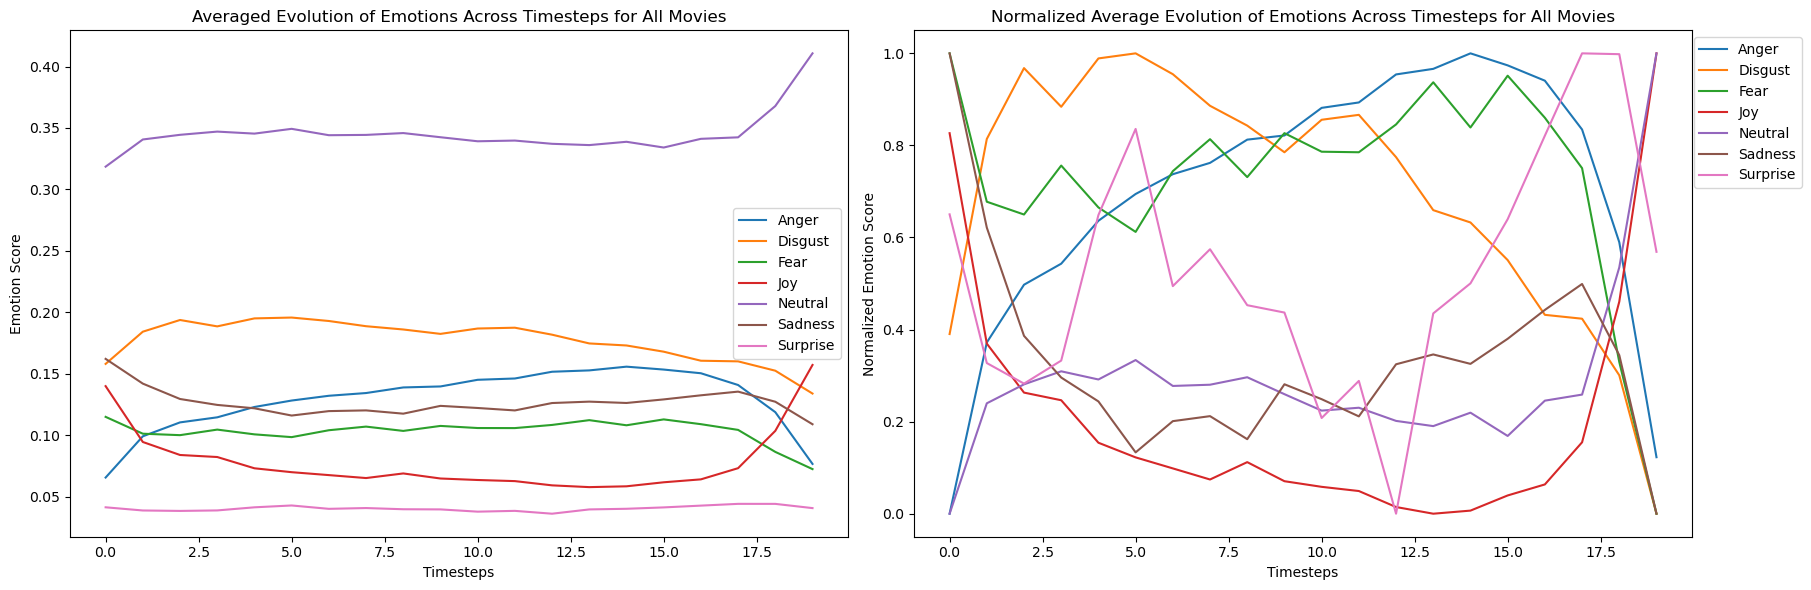

In [13]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
avg_emotions = interpolated_df.groupby("timestep")[emotions].mean()

#avg_emotions = avg_emotions[:target_timesteps]

#MinMax Normalization
normalized_emotions = avg_emotions.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

#ZScore Normalization
#normalized_emotions= avg_emotions.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
#normalized_emotions = avg_emotions
fig, axes = plt.subplots(1, 2,figsize=(18, 6))
axes = axes.ravel()
for emotion in emotions:
    axes[0].plot(range(target_timesteps), avg_emotions[emotion], label=emotion.capitalize())
    axes[1].plot(range(target_timesteps), normalized_emotions[emotion], label=emotion.capitalize())
axes[0].set_title("Averaged Evolution of Emotions Across Timesteps for All Movies")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Emotion Score")
axes[0].legend(loc="best")
axes[1].set_title("Normalized Average Evolution of Emotions Across Timesteps for All Movies")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Normalized Emotion Score")
axes[1].legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

### Now we can try for movies in already formed genres

In [137]:
df_exploded = interpolated_df.merge(df_metadata[["Wikipedia_movie_ID","category"]], on="Wikipedia_movie_ID")
df_exploded = df_exploded.explode("category")
df_grouped_by_genre = df_exploded.groupby("category")


In [138]:
df_grouped_by_genre = df_exploded.groupby(["category", "timestep"])[emotions].mean()
df_grouped_by_genre


anger   disgust      fear       joy   neutral  \
category         timestep                                                     
Action/Adventure 0         0.066540  0.158170  0.115147  0.136765  0.312444   
                 1         0.106388  0.179040  0.097174  0.090381  0.343654   
                 2         0.112624  0.192289  0.095612  0.080071  0.352053   
                 3         0.116872  0.189911  0.105522  0.078756  0.344649   
                 4         0.128178  0.202720  0.096689  0.068721  0.349219   
...                             ...       ...       ...       ...       ...   
War/Crime        15        0.154698  0.151563  0.112976  0.061043  0.347516   
                 16        0.147422  0.149593  0.107858  0.065546  0.357334   
                 17        0.148052  0.151862  0.118026  0.071572  0.333238   
                 18        0.113019  0.137654  0.089043  0.102427  0.385446   
                 19        0.069492  0.131706  0.080817  0.144945  0.426901   

                            sadness  surprise  
category         timestep                      
Action/Adventure 0         0.169829  0.041105  
                 1         0.142573  0.040790  
                 2         0.129488  0.037864  
                 3         0.122697  0.041592  
                 4         0.115827  0.038646  
...                             ...       ...  
War/Crime        15        0.131647  0.040559  
                 16        0.127632  0.044616  
                 17        0.134150  0.043101  
                 18        0.123950  0.048461  
                 19        0.109439  0.036700  

[280 rows x 7 columns]

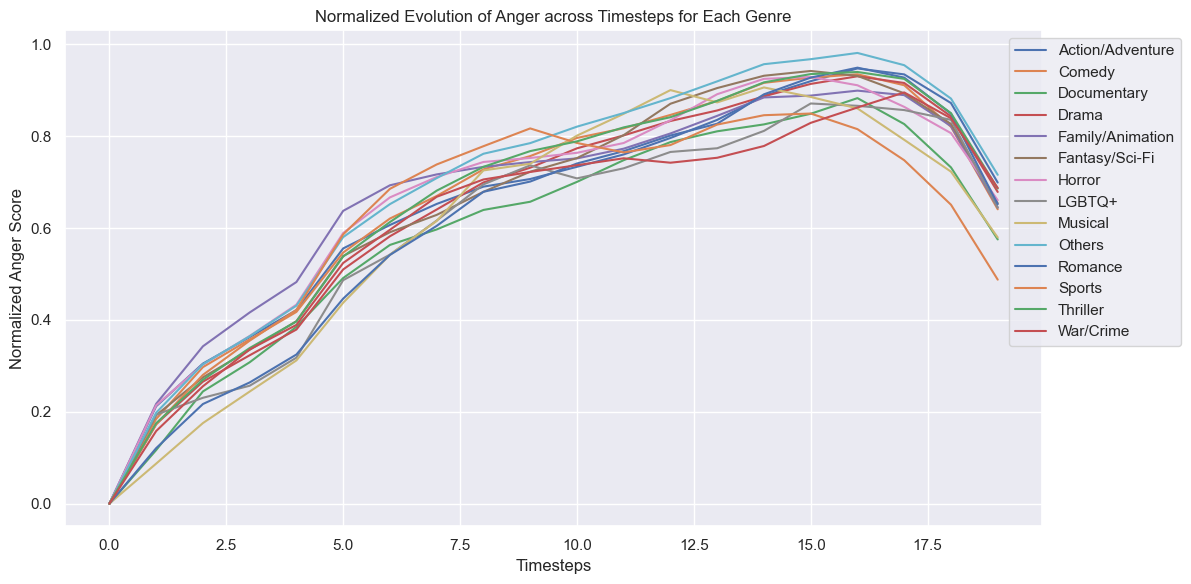

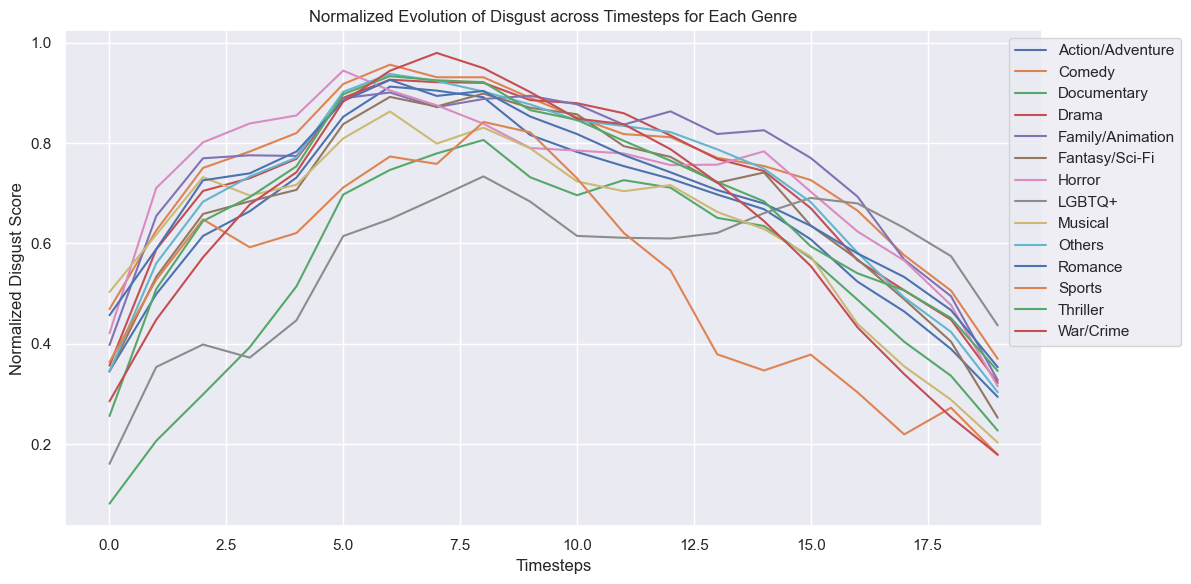

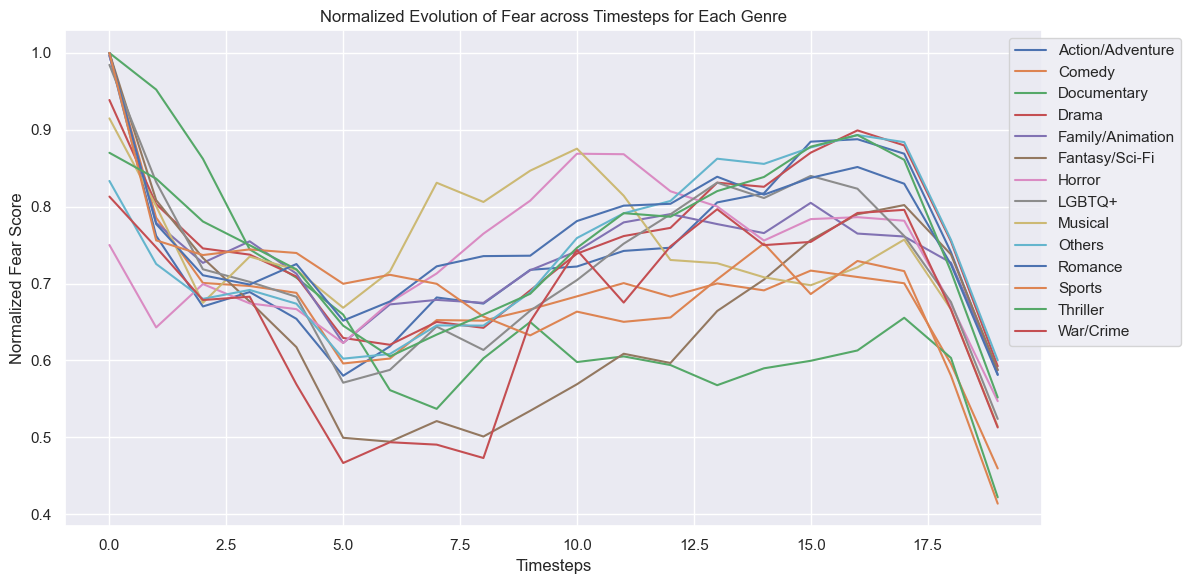

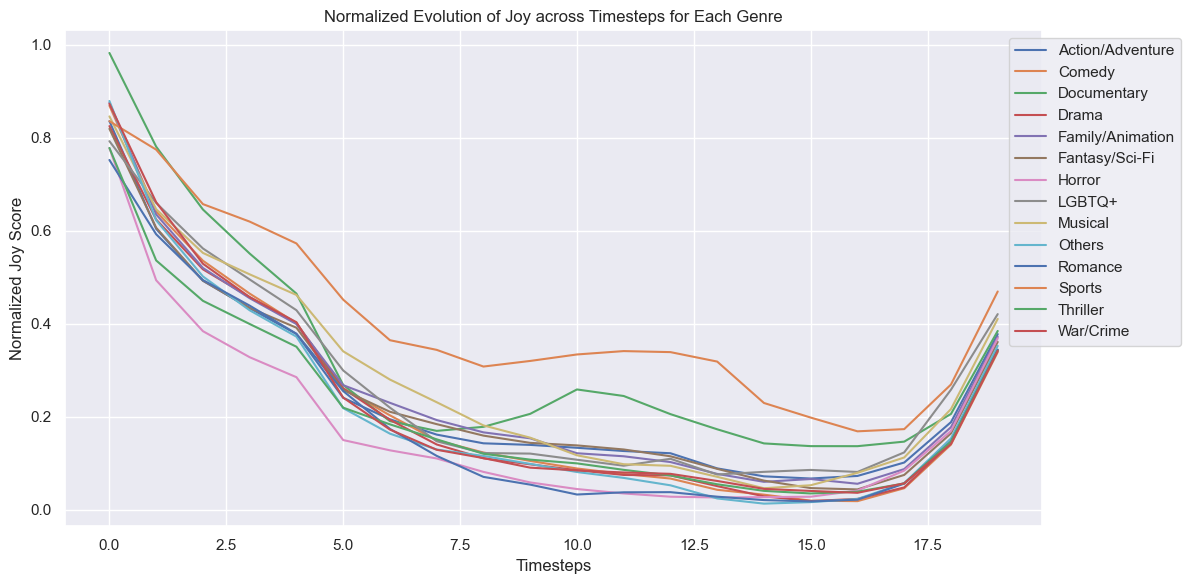

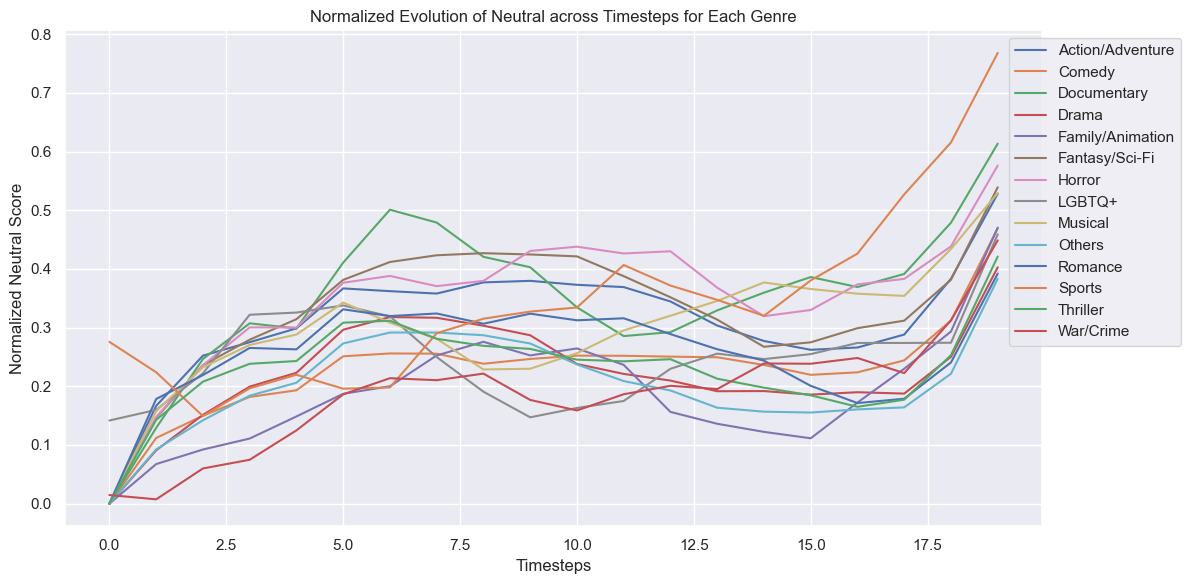

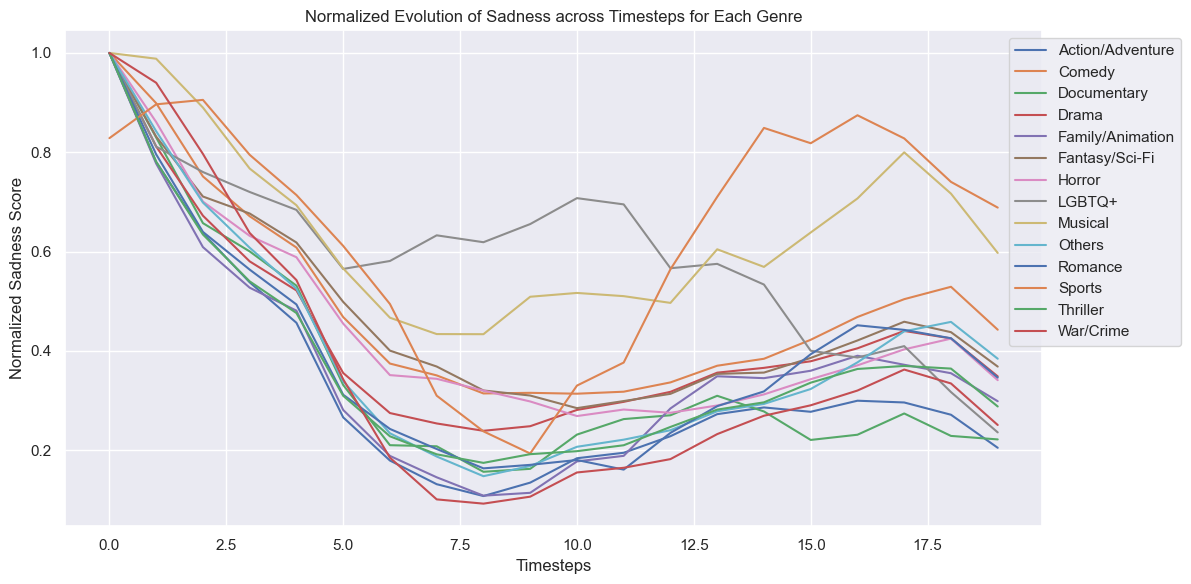

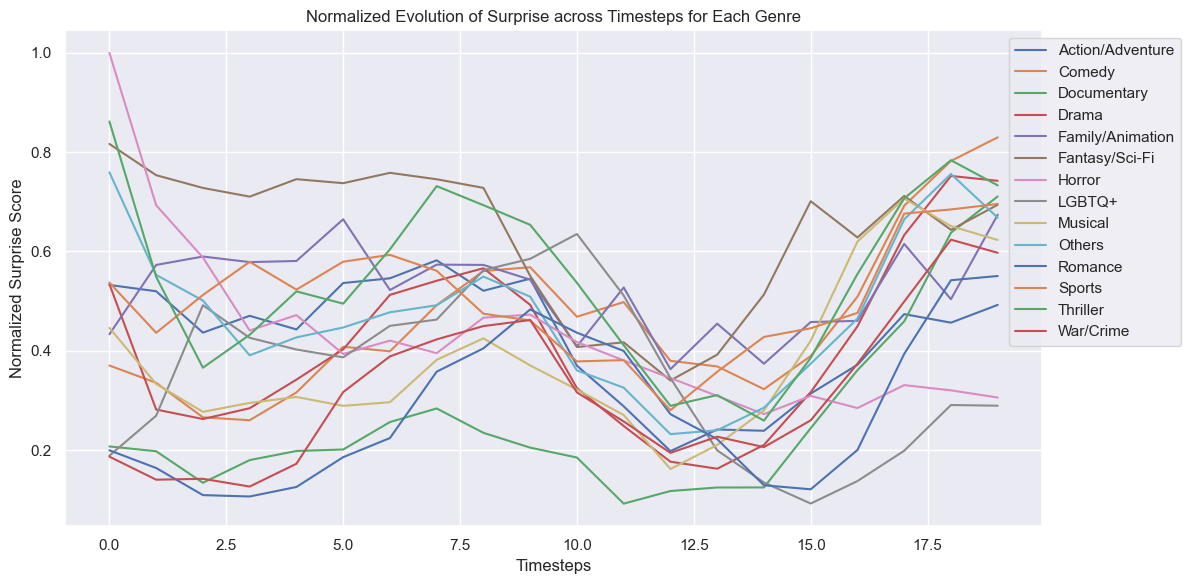

In [139]:
window_size = 5
for emotion in emotions:
    plt.figure(figsize=(12, 6))
    
    avg_emotion_by_genre = df_grouped_by_genre[emotion].unstack(level=0)

    avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    
    smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()
    for genre in smoothed_avg_emotion_by_genre.columns:
        plt.plot(smoothed_avg_emotion_by_genre.index, smoothed_avg_emotion_by_genre[genre], label=genre)
    plt.title(f"Normalized Evolution of {emotion.capitalize()} across Timesteps for Each Genre")
    plt.xlabel("Timesteps")
    plt.ylabel(f"Normalized {emotion.capitalize()} Score")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()
    

In [140]:
continents = ['Africa','Asia', 'Europe', 'North America', 'Oceania', 'South America']
df_exploded = interpolated_df.merge(df_metadata[["Wikipedia_movie_ID","category", "continent"]], on="Wikipedia_movie_ID")
df_exploded = df_exploded.explode("category")
df_groupy_by_continent = df_exploded.groupby(["continent","category", "timestep"])[emotions].mean()


In [141]:
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
dfs_par_continent = {}
for continent in continents:
    dfs_par_continent[continent] = df_groupy_by_continent.xs(continent, level='continent')
africa_df = dfs_par_continent['Africa']
asia_df = dfs_par_continent['Asia']
europe_df = dfs_par_continent['Europe']
na_df = dfs_par_continent['North America']
oceania_df = dfs_par_continent['Oceania']
sa_df = dfs_par_continent['South America']
dfs = [africa_df, asia_df, europe_df, na_df, oceania_df, sa_df]
#sa_df.merge(df_metadata[["Wikipedia_movie_ID", "Movie_box_office_revenue"]], on="Wikipedia_movie_ID")


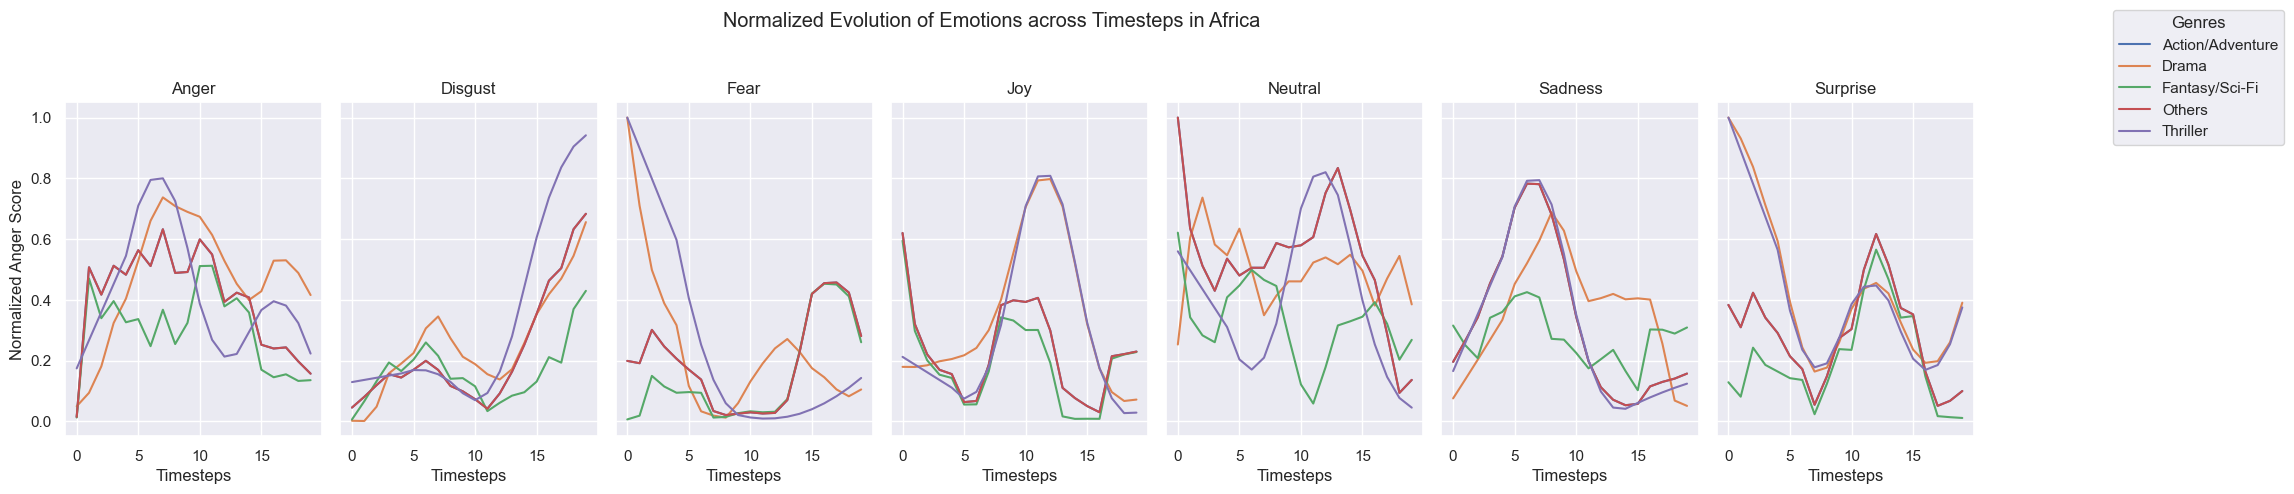

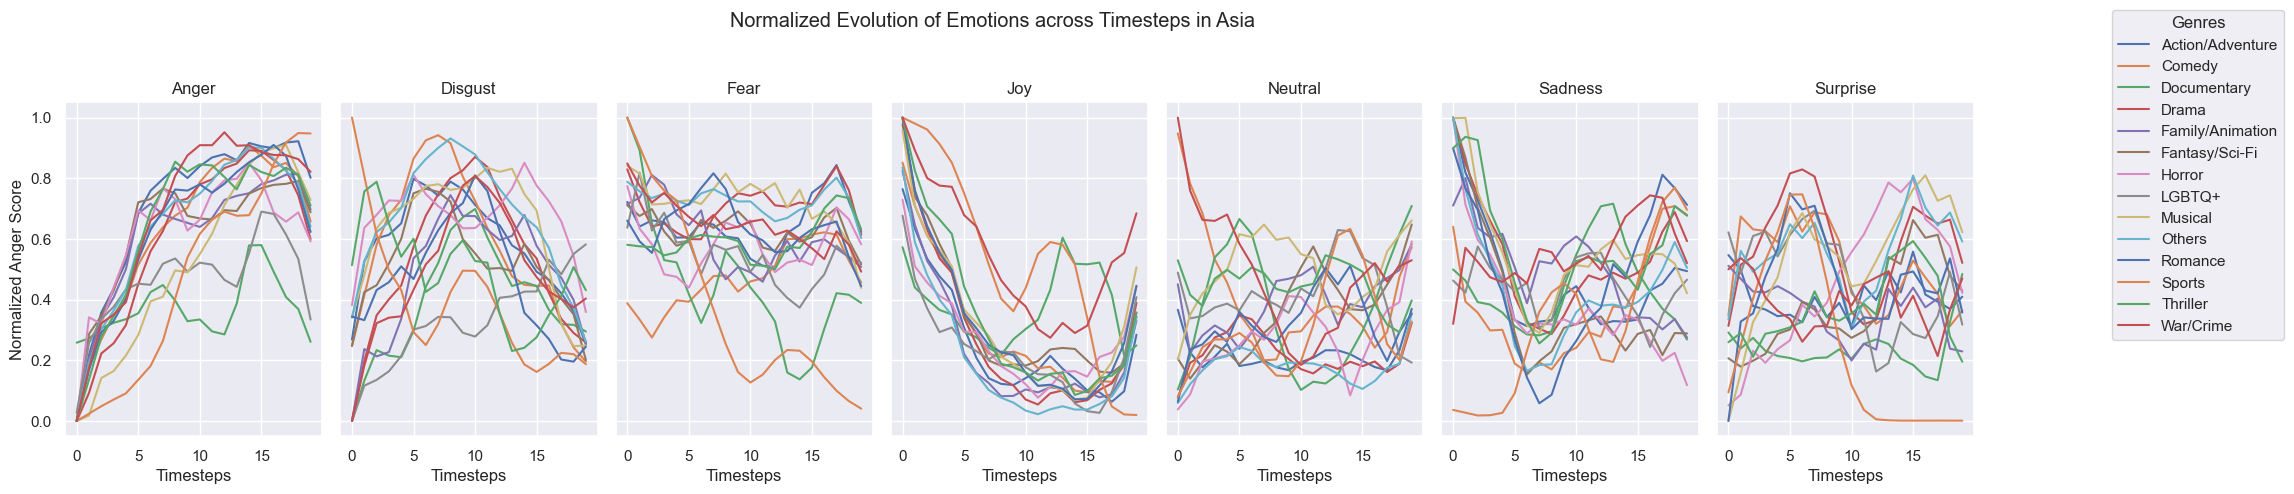

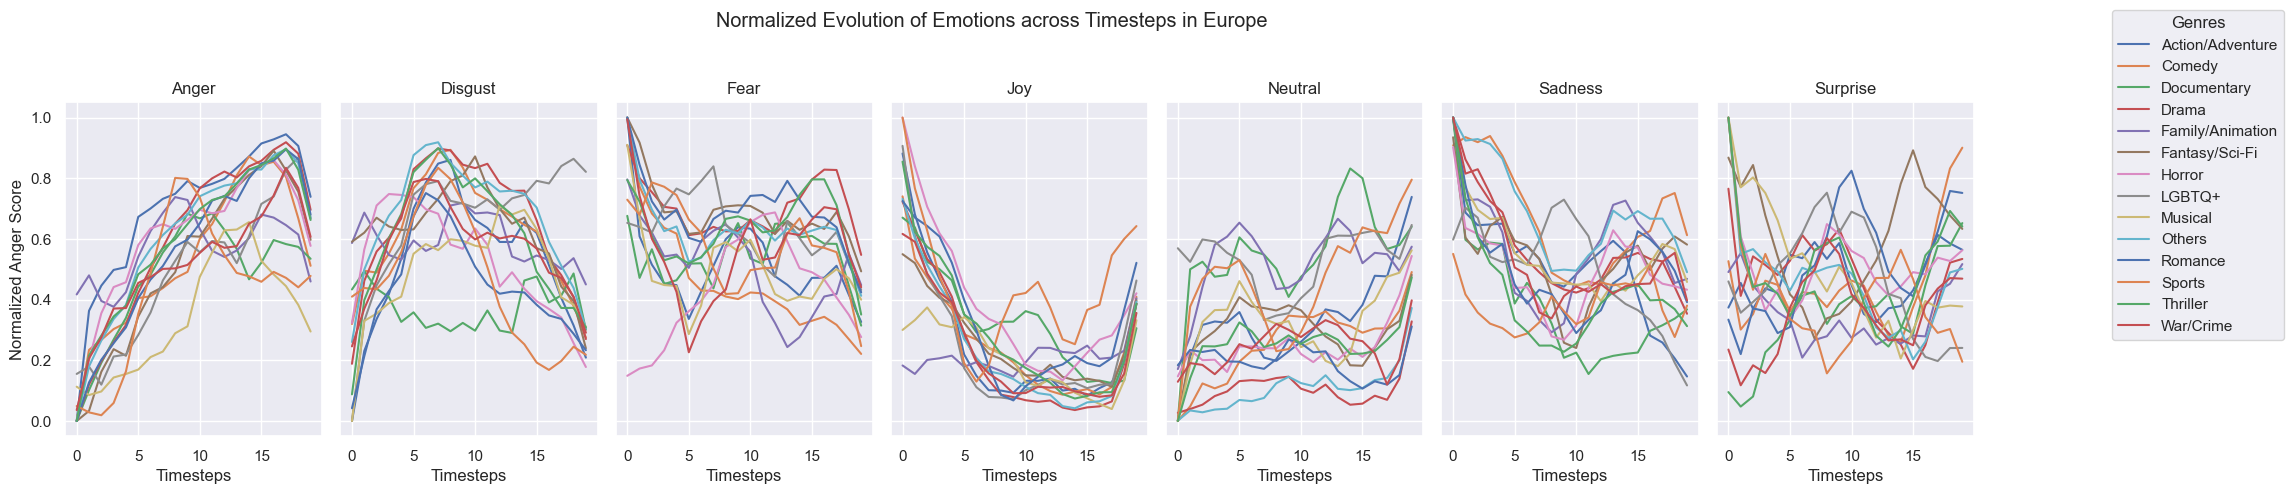

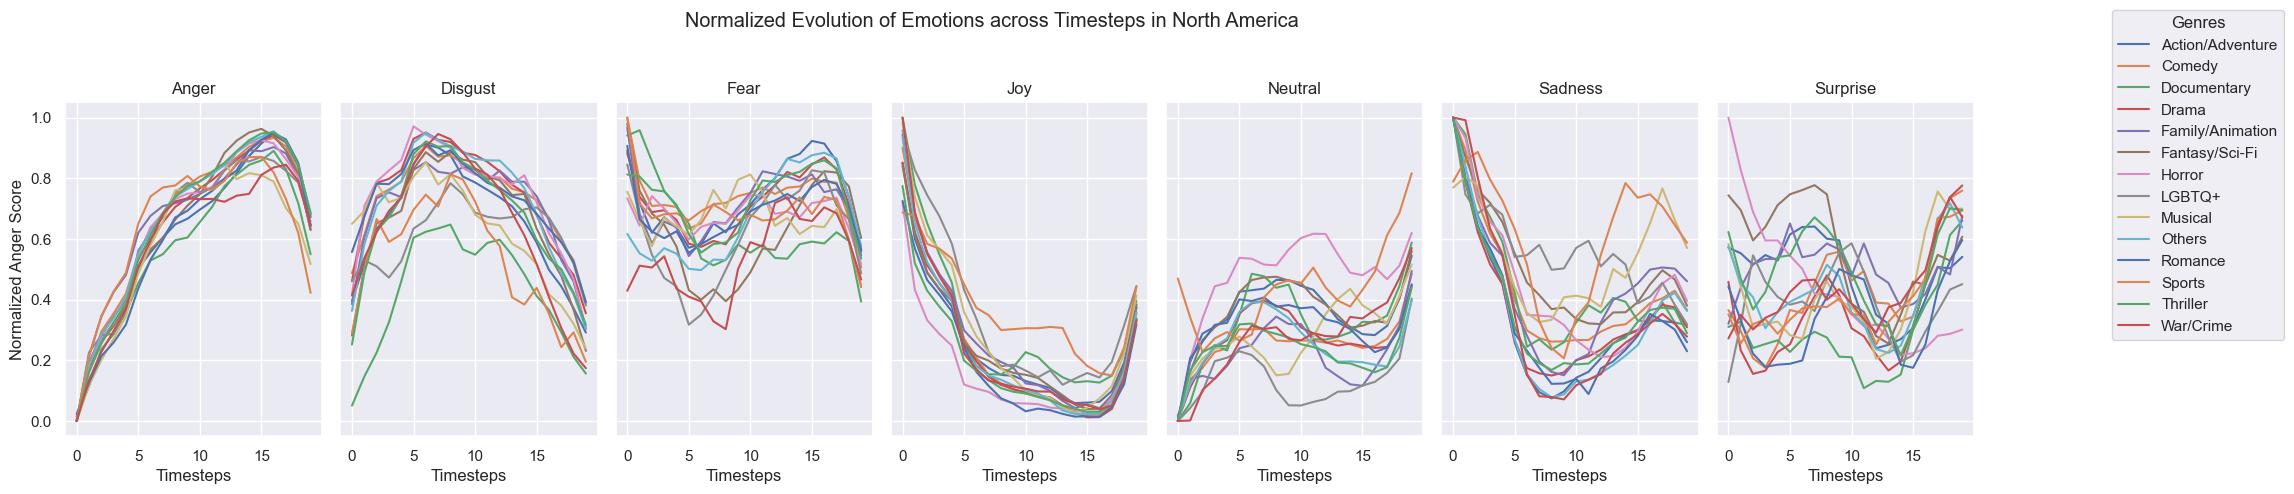

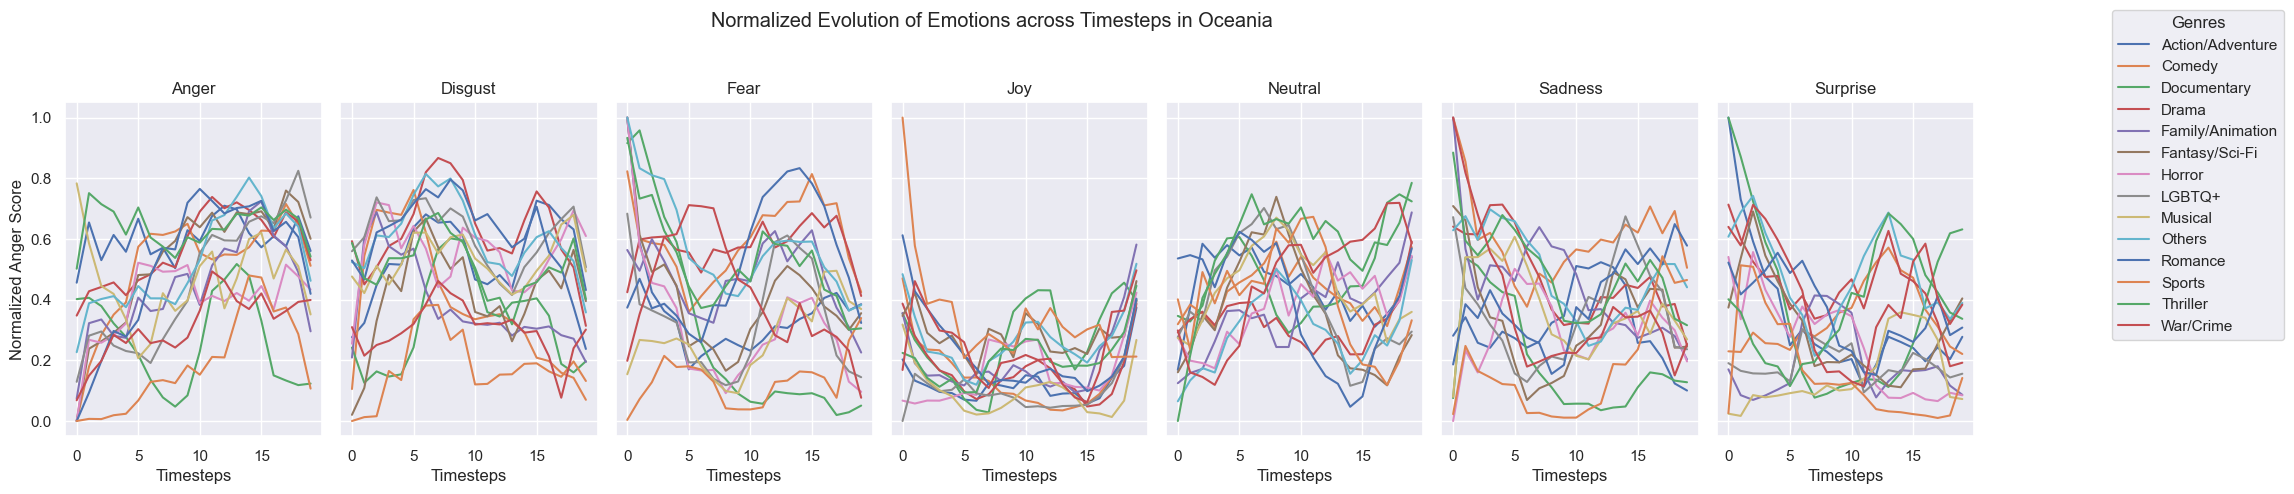

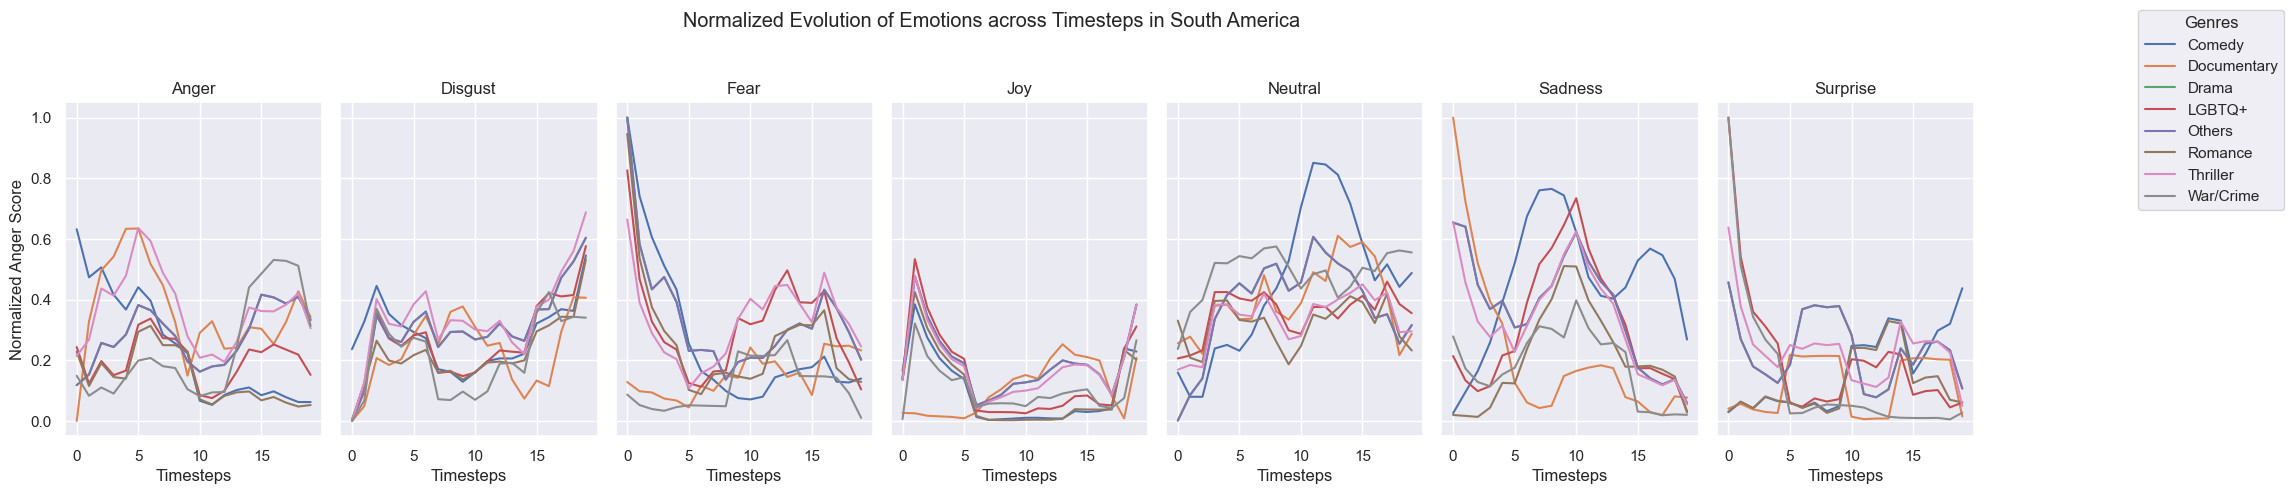

In [142]:
sns.set(style="darkgrid")

window_size = 5

for continent_name, df_continent in zip(continents, dfs):
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps in {continent_name}")

    handles = []
    labels = []
    legend_created = False

    for ax, emotion in zip(axes, emotions):
        avg_emotion_by_genre = df_continent[emotion].unstack(level=0)

        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        for genre in smoothed_avg_emotion_by_genre.columns:
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre
            )

        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        ax.get_legend().remove()

        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()


## using box office now

In [143]:
df_boxoffice = interpolated_df.iloc[::20].merge(df_metadata[["Wikipedia_movie_ID","category", "Movie_box_office_revenue", "Movie_runtime", 'Movie_release_date']], on="Wikipedia_movie_ID")
df_boxoffice = df_boxoffice.dropna(axis=0)
#df_boxoffice['Movie_release_date'] = (df_boxoffice['Movie_release_date'] - df_boxoffice['Movie_release_date'].min())/((df_boxoffice['Movie_release_date'].max() - df_boxoffice['Movie_release_date'].min()))
#df_boxoffice['Movie_runtime'] = (df_boxoffice['Movie_runtime'] - df_boxoffice['Movie_runtime'].min())/((df_boxoffice['Movie_runtime'].max() - df_boxoffice['Movie_runtime'].min()))
df_boxoffice = df_boxoffice.drop(['Wikipedia_movie_ID', 'timestep'], axis=1).explode('category')


In [144]:
df_boxoffice = pd.get_dummies(df_boxoffice, columns=['category'])
df_boxoffice

anger   disgust      fear       joy   neutral   sadness  surprise  \
1     0.040454  0.007021  0.818398  0.002523  0.061496  0.003478  0.066630   
1     0.040454  0.007021  0.818398  0.002523  0.061496  0.003478  0.066630   
1     0.040454  0.007021  0.818398  0.002523  0.061496  0.003478  0.066630   
1     0.040454  0.007021  0.818398  0.002523  0.061496  0.003478  0.066630   
1     0.040454  0.007021  0.818398  0.002523  0.061496  0.003478  0.066630   
...        ...       ...       ...       ...       ...       ...       ...   
4980  0.009714  0.037665  0.018552  0.095223  0.695286  0.010807  0.132753   
4980  0.009714  0.037665  0.018552  0.095223  0.695286  0.010807  0.132753   
4989  0.059548  0.571327  0.033367  0.002585  0.195038  0.132653  0.005482   
4994  0.007828  0.007820  0.003885  0.342822  0.492425  0.091236  0.053985   
4994  0.007828  0.007820  0.003885  0.342822  0.492425  0.091236  0.053985   

      Movie_box_office_revenue  Movie_runtime  Movie_release_date  ...  \
1                   21502796.0           81.0              1992.0  ...   
1                   21502796.0           81.0              1992.0  ...   
1                   21502796.0           81.0              1992.0  ...   
1                   21502796.0           81.0              1992.0  ...   
1                   21502796.0           81.0              1992.0  ...   
...                        ...            ...                 ...  ...   
4980                14069721.0           92.0              2002.0  ...   
4980                14069721.0           92.0              2002.0  ...   
4989                17014653.0           88.0              1995.0  ...   
4994                21134374.0           90.0              1982.0  ...   
4994                21134374.0           90.0              1982.0  ...   

      category_Family/Animation  category_Fantasy/Sci-Fi  category_Horror  \
1                          True                    False            False   
1                         False                    False            False   
1                         False                    False            False   
1                         False                    False             True   
1                         False                    False            False   
...                         ...                      ...              ...   
4980                      False                    False            False   
4980                      False                    False            False   
4989                      False                    False            False   
4994                      False                    False            False   
4994                      False                    False            False   

      category_LGBTQ+  category_Musical  category_Others  category_Romance  \
1               False             False            False             False   
1               False             False            False             False   
1               False             False             True             False   
1               False             False            False             False   
1               False             False            False             False   
...               ...               ...              ...               ...   
4980            False             False            False             False   
4980            False             False            False             False   
4989            False             False            False             False   
4994            False             False            False             False   
4994            False             False             True             False   

      category_Sports  category_Thriller  category_War/Crime  
1               False              False               False  
1               False              False               False  
1               False              False               False  
1               False              False               False  
1     

In [145]:
X = df_boxoffice.drop(columns=["Movie_box_office_revenue"])
y = df_boxoffice["Movie_box_office_revenue"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) #test_size = 0.15 yiels better r2 score than .2

pipeline = Pipeline([
    #("scaler", StandardScaler()), #jsp si c'est obligatoire
    ("regressor", RandomForestRegressor(random_state=42))  
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [146]:

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)
mean_boxoffice = y_test.mean()
print(f"mean of boxoffice = {int(mean_boxoffice)}")
std_boxoffice = y_test.std()
print(f"std of boxoffice = {int(std_boxoffice)}")

Mean Absolute Error (MAE): 25499805.967376426
Mean Squared Error (MSE): 2337170386367490.0
Root Mean Squared Error (RMSE): 48344290.111320175
R-squared (R²): 0.8904834156481415
mean of boxoffice = 87960566
std of boxoffice = 146154352


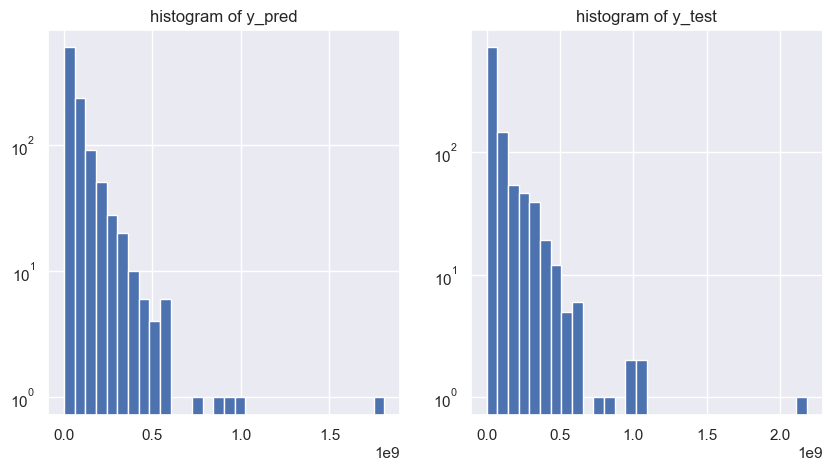

In [147]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
axes[0].hist(y_pred, bins=30)
axes[0].set_yscale('log')
axes[0].set_title('histogram of y_pred')
axes[1].hist(y_test,bins=30)
axes[1].set_title('histogram of y_test')
axes[1].set_yscale('log')

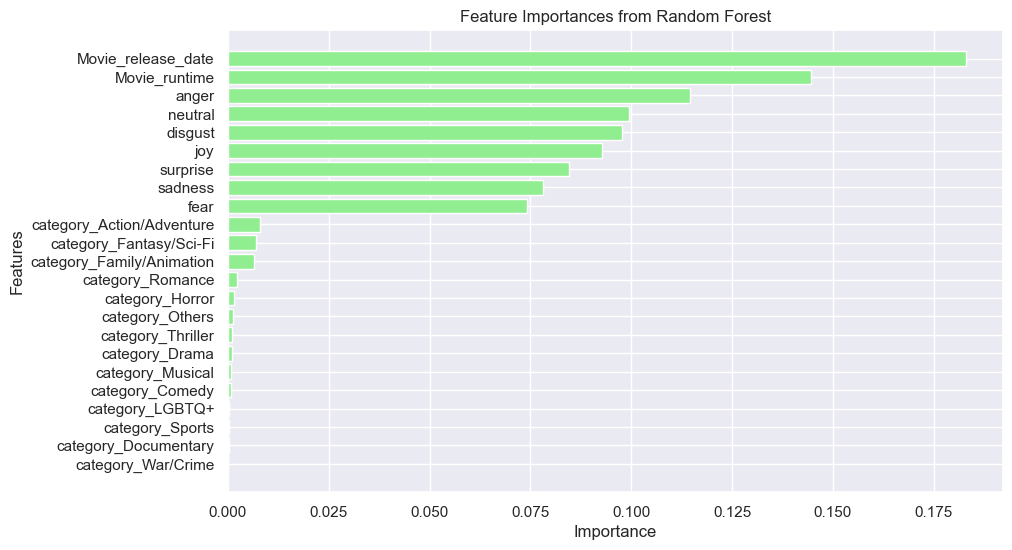

In [148]:
model = pipeline.named_steps['regressor']

feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightgreen')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest")
plt.gca().invert_yaxis()  
plt.show()

In [149]:
df_boxoffice = interpolated_df.iloc[::20].merge(df_metadata[["Wikipedia_movie_ID","category", "continent", "Movie_box_office_revenue"]], on="Wikipedia_movie_ID")
df_boxoffice[df_boxoffice['continent'] == 'South America']
df_boxoffice = df_boxoffice.dropna(subset=['Movie_box_office_revenue'], axis=0)[['category', 'continent', 'Movie_box_office_revenue']]
df_boxoffice = df_boxoffice.explode('category')
#df_boxoffice

In [150]:
df_boxoffice_mean_by_category_and_genre = df_boxoffice.groupby(['category', 'continent']).mean()


In [151]:
df_boxoffice_mean_by_category_and_genre =df_boxoffice_mean_by_category_and_genre.reset_index()
continents = np.unique(df_boxoffice_mean_by_category_and_genre['continent'])

In [156]:
continents

array(['Asia', 'Europe', 'North America', 'Oceania'], dtype=object)

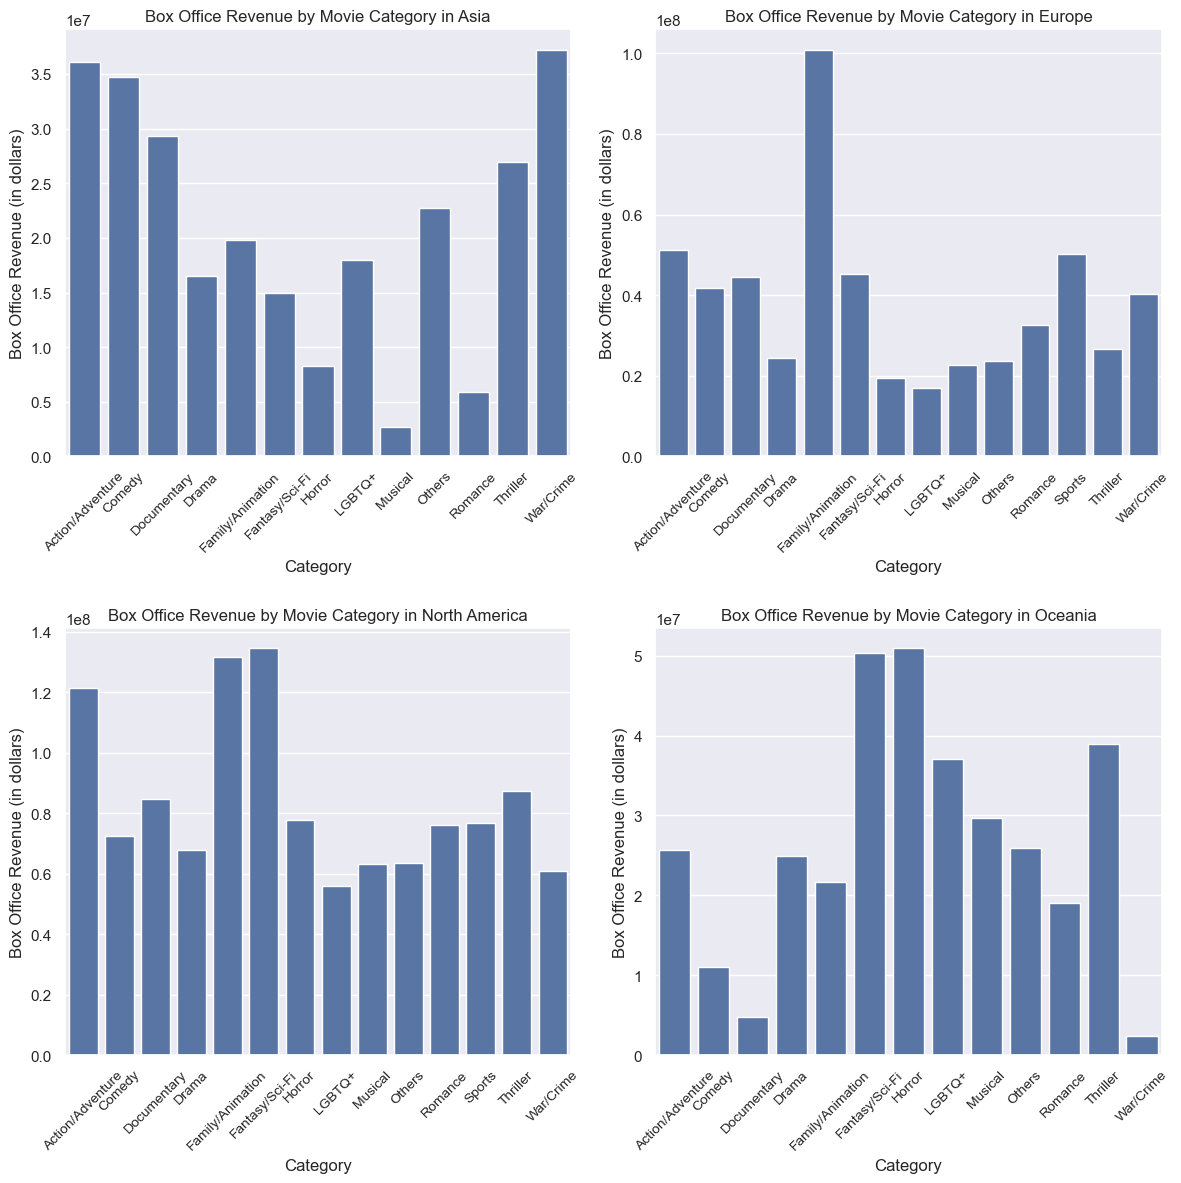

In [171]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
for ax, continent in zip(axes, continents):
    df = df_boxoffice_mean_by_category_and_genre[df_boxoffice_mean_by_category_and_genre['continent'] == continent]
    sns.barplot(data=df, x="category", y="Movie_box_office_revenue", ax=ax)

    ax.set_title(f"Box Office Revenue by Movie Category in {continent}")
    ax.set_xlabel("Category")
    ax.set_ylabel("Box Office Revenue (in dollars)")
    ax.tick_params(axis='x', rotation=45, labelright=False, labelsize=10)
plt.tight_layout()
